# Предсказание коэффициента восстановления золота из руды

**Задача** - подготовка прототипа модели ML для предсказания коэф-та восстановления золота

**Ключевые шаги**  
1. Обработка и подготовка данных;
2. Исследовательский анализ данных;
3. Создание функции sMAPE;
4. Определение параметров модели;
5. Построение моделей, предсказывающих вектор из двух значений

**Описание**  
Нам предоставлены данные с параметрами разных этапов добычи и очистки металлов из руды. Для эффективной работы промышленного предприятия необходимо оптимизировать производство, то есть "настроить" правильно процессы восстановления золота из золотосодержащей руды.  
Всего 4 стадии очистки добытой руды: первичная обработка, флотация, двухэтапная очистка. После каждой стадии появляются отвальные хвосты. На каждом этапе чистки происходит регуляция параметров: воздуха, воды, также меняется размер гранул и скорость подачи.  
Для расчёта эффективности предлагается использовать метрику Recovery, а для решения задачи - sMAPE (MAE в относительных величинах).  
Так как на финальный результат влияют промежуточные метрики, требуется предсказать 2 признака - эфф-ть обогащения чернового и финального концентратов и на их основе посчитать финальное sMAPE (предсказать двойной таргет).

**Библиотеки**  
Pandas, numpy, sklearn, matplotlib

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('max_columns', None)

По условию данные были сразу разделены на тренировочную и тестовую выборки, но нам также доступны полные данные

In [3]:
df_train = pd.read_csv('gold_recovery_train.csv')
df_test = pd.read_csv('gold_recovery_test.csv')
df_full = pd.read_csv('gold_recovery_full.csv')

#### Обзор данных  <a id="overview"></a>

In [4]:
print("Размер полной выборки:", df_full.shape)
print("Размер обучающей выборки:", df_train.shape)
print("Размер тестовой выборки:", df_test.shape)

Размер полной выборки: (22716, 87)
Размер обучающей выборки: (16860, 87)
Размер тестовой выборки: (5856, 53)


In [5]:
print('Период\n', df_full['date'].min(), '-', df_full['date'].max())

Период
 2016-01-15 00:00:00 - 2018-08-18 10:59:59


In [6]:
pd.to_datetime(df_train['date']).dt.to_period('m').unique()

<PeriodArray>
['2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07',
 '2016-08', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
 '2017-07', '2017-08', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05',
 '2018-06', '2018-07', '2018-08']
Length: 24, dtype: period[M]

In [7]:
pd.to_datetime(df_test['date']).dt.to_period('m').unique()

<PeriodArray>
['2016-09', '2016-10', '2016-11', '2016-12', '2017-09', '2017-10', '2017-11',
 '2017-12']
Length: 8, dtype: period[M]

Обучающая и тестовая выборки по умолчанию были поделены таким образом, что в тестовой присутствовали по 4 последних месяца 16-17 гг., а в обучающей 1-8 месяцы.

In [8]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,127.09,10.13,7.25,0.99,8.55,10.39,19.53,34.17,14.94,2.53,7.48,2.11,1549.78,-498.91,1551.43,-516.40,1549.87,-498.67,1554.37,-493.43,41885.71,3481.78,3520.34,2.84,6.10,2.28,523.55,55.49,36.81,6.49,11.99,6.01,11.84,6.01,11.50,7.10,28.03,19.79,87.11,5.01,0.51,19.15,1.17,999.71,-404.07,1603.01,-434.72,1602.38,-442.20,1598.94,-451.29,1404.47,-455.46,1416.35,-451.94,14.50,4.69,8.76,2.61,25.85,-498.53,23.89,-501.41,23.96,-495.26,21.94,-499.34,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
1,2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,125.63,10.30,7.25,1.00,8.56,10.50,19.37,34.12,16.25,3.05,6.73,2.35,1576.17,-500.90,1575.95,-499.87,1575.99,-499.32,1574.48,-498.93,42050.86,3498.37,3489.98,2.86,6.16,2.27,525.29,57.28,35.75,6.48,11.97,6.01,12.00,6.01,11.62,7.28,28.07,20.05,86.84,4.96,0.54,18.97,1.18,1000.29,-400.07,1600.75,-449.95,1600.48,-449.83,1600.53,-449.95,1399.23,-450.87,1399.72,-450.12,14.27,4.59,9.00,2.49,25.88,-499.99,23.89,-500.37,23.97,-500.

**Пропуски**

In [9]:
df_full.isnull().sum().sort_values(ascending = False).head(10)

rougher.output.recovery               3119
rougher.output.tail_ag                2737
rougher.output.tail_sol               2736
rougher.output.tail_au                2736
rougher.input.floatbank11_xanthate    2257
secondary_cleaner.output.tail_sol     2215
final.output.recovery                 1963
rougher.calculation.au_pb_ratio       1627
primary_cleaner.input.sulfate         1609
primary_cleaner.input.depressant      1546
dtype: int64

Нам предосталвены данные за период 01.2016 - 08.2018, которые характеризуют разные этапы восстановления золота (очистки) из смеси руды. Одно наблюдение описывает разные стадии обработки в течение часа.  
В данных присутствуют пропущенные значения, в том числе и в целевых признаках, далее рассмотрим их подробнее.

#### Проверим, какие переменные отсутствуют в тестовой выборке

In [10]:
set(df_full.columns).difference(set(df_test.columns))

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

**Вывод.** В тестовой выборке отсутствует 34 переменные: 2 целевые, а также переменные по всем металлам, по которым можно рассчитать эффективность обогащения. Это переменные, которые невозможно измерить во время выполнения технологического процесса.  
Так как целевой признак рассчитывается из данных переменных, то важнее исследовать, что влияет на получение концентраций металлов и отвальных хвостов на разных этапах очистки, т.к. чем больше концентрация au и меньше хвосты, тем выше эффективность восстановления. 

#### Группировка переменных

Для удобства саккумулируем переменные по группам

In [11]:
date = ['date']

In [12]:
# Эффективности обогащения на разных стадиях, целевые признаки
recovery = ['rougher.output.recovery', 'final.output.recovery']

In [13]:
# Параметры этапов
size_rate = ['rougher.input.feed_rate', 'rougher.input.feed_size', 'primary_cleaner.input.feed_size']

In [14]:
# Доля металлов в сырье на начальном этапе
feed = ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au']

In [15]:
# Расчётные характеристики
calculation = ['rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 
               'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio']

In [16]:
# Флотационные реагенты, добавленные в установку
rougher_input = ['rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate',
                 'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate']

In [17]:
# Параметры флотационного этапа
rougher_state = ['rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
               'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level',
               'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level',
               'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level',
               'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level',
               'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level']

In [18]:
# Концентраты металлов после флотации
rougher_concentrate = ['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 
                       'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']

In [19]:
# Отвальные хвосты после флотации
rougher_tails = ['rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tail_au']

In [20]:
# Реагенты, добавленные в установку на 1ом этапе очистки
primary_input = ['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.xanthate']

In [21]:
# Параметры этапа 1ой очистки
primary_state = ['primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_a_level',
                 'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_b_level',
                 'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_c_level',
                 'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.state.floatbank8_d_level']

In [22]:
# Концентраты металлов после 1го этапа очистки
primary_concentrate = ['primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb',
                       'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au']

In [23]:
# Отвальные хвосты после 1го этапа очистки
primary_tails = ['primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
                 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au']

In [24]:
# Параметры этапа 2ой очистки
secondary_state = ['secondary_cleaner.state.floatbank2_a_air', 'secondary_cleaner.state.floatbank2_a_level',
                   'secondary_cleaner.state.floatbank2_b_air', 'secondary_cleaner.state.floatbank2_b_level',
                   'secondary_cleaner.state.floatbank3_a_air', 'secondary_cleaner.state.floatbank3_a_level',
                   'secondary_cleaner.state.floatbank3_b_air', 'secondary_cleaner.state.floatbank3_b_level',
                   'secondary_cleaner.state.floatbank4_a_air', 'secondary_cleaner.state.floatbank4_a_level',
                   'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank4_b_level',
                   'secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank5_a_level',
                   'secondary_cleaner.state.floatbank5_b_air', 'secondary_cleaner.state.floatbank5_b_level',
                   'secondary_cleaner.state.floatbank6_a_air', 'secondary_cleaner.state.floatbank6_a_level']

In [25]:
# Отвальные хвосты на 2ом этапе очистки
secondary_tails = ['secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb',
                   'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_au']

In [26]:
# Финальные концентраты металлов
final_concentrate = ['final.output.concentrate_ag', 'final.output.concentrate_pb',
                    'final.output.concentrate_sol', 'final.output.concentrate_au']

In [27]:
# Отвальные хвосты на финальном этапе
final_tails = ['final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au']

### Обработка пропусков         <a id="miss"></a>

####  Пропуски в переменных rougher.input.feed_

In [28]:
df_full[df_full['rougher.input.feed_au'].isna()==True].head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
746,2016-02-15 02:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,7.03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1310,2016-03-09 14:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,7.79,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1311,2016-03-09 15:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,7.79,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan

In [29]:
print("Кол-во дубликатов", len(df_full[df_full.drop('date', axis=1).duplicated()]))
display(df_full[df_full.drop('date', axis=1).duplicated()].head(3))

Кол-во дубликатов 22


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
1311,2016-03-09 15:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,7.79,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1312,2016-03-09 16:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,7.79,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
8299,2016-12-25 18:59:59,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,7.41,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na

Дубликаты - строки с большим кол-вом пропусков

In [30]:
df_full[feed].isnull().sum()

rougher.input.feed_ag      98
rougher.input.feed_pb     244
rougher.input.feed_sol    359
rougher.input.feed_au      99
dtype: int64

In [31]:
df_full = df_full.dropna(subset=['rougher.input.feed_au','rougher.input.feed_ag']).reset_index(drop = True)

In [32]:
df_train[feed].isnull().sum()

rougher.input.feed_ag      82
rougher.input.feed_pb     228
rougher.input.feed_sol    292
rougher.input.feed_au      83
dtype: int64

In [33]:
df_train = df_train.dropna(subset=['rougher.input.feed_au','rougher.input.feed_ag']).reset_index(drop = True)

In [34]:
df_train[feed].isnull().sum()

rougher.input.feed_ag       0
rougher.input.feed_pb     146
rougher.input.feed_sol    210
rougher.input.feed_au       0
dtype: int64

In [35]:
df_test[feed].isnull().sum()

rougher.input.feed_ag     16
rougher.input.feed_pb     16
rougher.input.feed_sol    67
rougher.input.feed_au     16
dtype: int64

In [36]:
df_test = df_test.dropna(subset=['rougher.input.feed_au','rougher.input.feed_ag']).reset_index(drop = True)

In [37]:
df_test[feed].isnull().sum()

rougher.input.feed_ag      0
rougher.input.feed_pb      0
rougher.input.feed_sol    51
rougher.input.feed_au      0
dtype: int64

Проверка

In [38]:
print(len(df_full[df_full.drop('date', axis=1).duplicated()]))
print('Кол-во строк после удаления', len(df_full))

0
Кол-во строк после удаления 22617


Дубликаты могут быть вызваны неправильным или случайным занесением данных, в основном это строки, где все значения отсутствуют. 
Удалили все строки с пропусками доли золота в сырье, т.к. без данных значений нельзя посчитать recovery, а их доля в выборке меньше 1 %.

#### Проверка пропусков в целевых переменных

In [39]:
df_full['final.output.recovery'].isnull().value_counts()

False    20753
True      1864
Name: final.output.recovery, dtype: int64

In [40]:
df_full[df_full['final.output.recovery'].isna()==True].head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
49,2016-01-17 01:00:00,7.26,9.02,nan,43.39,nan,12.10,1.76,4.61,3.20,48.76,5.02,7.25,0.60,9.94,7.04,18.54,35.87,18.20,3.44,1.74,4.64,1601.02,-498.65,1602.90,-501.14,1600.57,-499.32,1600.56,-499.75,50753.53,3704.99,3707.37,4.17,0.05,0.01,528.01,45.33,0.12,0.03,6.00,6.33,6.00,6.33,0.00,0.00,0.00,0.00,0.00,4.97,0.57,10.89,2.04,993.91,-500.87,1595.46,-499.68,1597.02,-499.52,1390.67,-500.21,1199.78,-499.35,1200.75,-494.81,14.35,5.61,3.53,5.40,26.04,-419.37,23.99,-501.01,24.90,-499.89,23.96,-499.65,14.03,-549.33,11.99,-549.58,10.09,-492.04,8.05,-498.80,11.96,-597.27
99,2016-01-19 03:00:00,0.00,0.00,0.00,0.00,nan,0.00,0.00,0.00,0.00,2.12,nan,7.25,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1549.05,-500.27,1548.15,-500.14,1551.25,-500.10,1549.61,-500.34,652.62,-1607.69,-276.56,nan,0.00,0.00,0.34,30.53,0.00,0.00,nan,0.01,nan,nan,0.00,0.00,0.00,0.00,nan,nan,0.00,nan,nan,1000.04,-499.70,1601.26,-500.21,1602.15,-501.17,1403.70,-500.47,1200.04,-500.72,1100.26,-501.59,0.00,0.00,0.00,0.00,25.02,-498.79,22.95,-499.97,24.01,-499.77,23.02,-500.24,13.99,-799.60,12.04,-603.23,

In [41]:
df_full['rougher.output.recovery'].isnull().value_counts()

False    19597
True      3020
Name: rougher.output.recovery, dtype: int64

In [42]:
df_full[df_full['rougher.output.recovery'].isna()==True].head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
53,2016-01-17 05:00:00,5.92,11.08,6.22,42.92,71.31,10.87,1.58,17.55,2.48,137.33,13.94,7.25,1.20,10.10,9.97,19.34,33.53,15.53,2.88,6.71,2.72,1598.39,-500.46,1602.96,-500.42,1600.86,-499.99,1600.51,-500.26,39933.07,3203.46,3192.36,2.32,8.12,3.25,598.32,52.13,39.03,7.55,14.43,7.80,14.42,7.80,2.09,1.46,4.93,3.51,nan,5.10,0.91,18.13,2.19,999.66,-500.03,1599.27,-501.55,1600.10,-501.70,1403.53,-501.24,1201.60,-500.54,1201.04,-506.31,12.98,4.91,9.90,2.74,26.08,-499.70,23.92,-500.09,25.01,-500.40,24.01,-499.85,13.97,-548.24,12.04,-550.43,9.99,-499.61,7.95,-500.35,12.01,-599.04
99,2016-01-19 03:00:00,0.00,0.00,0.00,0.00,nan,0.00,0.00,0.00,0.00,2.12,nan,7.25,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1549.05,-500.27,1548.15,-500.14,1551.25,-500.10,1549.61,-500.34,652.62,-1607.69,-276.56,nan,0.00,0.00,0.34,30.53,0.00,0.00,nan,0.01,nan,nan,0.00,0.00,0.00,0.00,nan,nan,0.00,nan,nan,1000.04,-499.70,1601.26,-500.21,1602.15,-501.17,1403.70,-500.47,1200.04,-500.72,1100.26,-501.59,0.00,0.00,0.00,0.00,25.02,-498.79,22.95,-499.97,24.01,-499.77,23.02,-500.24,13.99,-799.60,12.04

Пропуски в целевых переменных связаны с пропусками в расчётных данных, концентратов au, отвальных хвостов, доли золота в смеси руды.  
Проведём обработку пропусков в этих переменных

#### Рассмотрим подробнее нулевые концентраты

В выборках существуют пропуски в переменных эффективности, в то же время все концентраты металлов = 0, такие значения могли появиться ошибочным путём, например, при механической очистке, потому как они следуют друг за другом по времени. Такие данные не могут дать нам релевантные результаты, поэтому исключим их из выборок.  
Например, это строки в диапазоне [17702:17832], который соответствует ночным часам и, возможно, производство не работало (также диапазон [99:129])

In [43]:
print('Кол-во строк с 0 концентрацией всех металлов -', len(df_full[(df_full['final.output.recovery'].isna() == True) & 
                                                                    (df_full['rougher.input.feed_au'] == 0)]))

print('% строк с нерелевантными данными - {:.1%}'.format(len(df_full[(df_full['final.output.recovery'].isna() == True) & 
                                                                     (df_full['rougher.input.feed_au'] == 0)])/len(df_full)))

Кол-во строк с 0 концентрацией всех металлов - 1528
% строк с нерелевантными данными - 6.8%


In [44]:
df_full[(df_full['final.output.recovery'].isna() == True) & (df_full['rougher.input.feed_au'] == 0)].head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
99,2016-01-19 03:00:00,0.00,0.00,0.00,0.00,nan,0.00,0.00,0.00,0.00,2.12,nan,7.25,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1549.05,-500.27,1548.15,-500.14,1551.25,-500.10,1549.61,-500.34,652.62,-1607.69,-276.56,nan,0.00,0.00,0.34,30.53,0.00,0.00,nan,0.01,nan,nan,0.00,0.00,0.00,0.00,nan,nan,0.00,nan,nan,1000.04,-499.70,1601.26,-500.21,1602.15,-501.17,1403.70,-500.47,1200.04,-500.72,1100.26,-501.59,0.00,0.00,0.00,0.00,25.02,-498.79,22.95,-499.97,24.01,-499.77,23.02,-500.24,13.99,-799.60,12.04,-603.23,9.97,-497.09,7.95,-499.70,11.94,-598.54
100,2016-01-19 04:00:00,0.00,0.00,0.00,0.00,nan,0.00,0.00,0.00,0.00,nan,nan,7.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1549.56,-500.30,1548.45,-500.00,1550.89,-499.43,1548.37,-499.85,-1113.25,-5862.02,738.07,nan,0.00,0.00,0.33,30.52,0.00,0.00,nan,0.00,0.00,nan,0.00,0.00,0.00,0.00,nan,nan,0.00,nan,nan,999.86,-500.41,1598.85,-500.26,1601.08,-501.17,1398.61,-500.91,1199.05,-500.44,1099.17,-499.97,0.00,0.00,0.00,0.00,25.02,-500.65,23.02,-500.26,23.98,-499.95,23.03,-500.04,14.03,-799.60,12.04,-623.45,9.90,-499.62,7.98,

Кол-во строк, где доля металлов = 0 для всех типов

In [45]:
len(df_full[(df_full['rougher.input.feed_ag'] == 0) & (df_full['rougher.input.feed_au'] == 0) & 
                                                      (df_full['rougher.input.feed_pb'] == 0)])

1528

In [46]:
len(df_train[(df_train['rougher.input.feed_ag'] == 0) & (df_train['rougher.input.feed_au'] == 0) & 
                                                      (df_train['rougher.input.feed_pb'] == 0)])

1159

In [47]:
len(df_test[(df_test['rougher.input.feed_ag'] == 0) & (df_test['rougher.input.feed_au'] == 0) & 
                                                      (df_test['rougher.input.feed_pb'] == 0)])

369

In [48]:
df_full_new = df_full[(df_full['rougher.input.feed_ag'] != 0) & (df_full['rougher.input.feed_au'] != 0) & 
                                          (df_full['rougher.input.feed_pb'] != 0)].reset_index(drop = True)

df_train_new = df_train[(df_train['rougher.input.feed_ag'] != 0) & (df_train['rougher.input.feed_au'] != 0) & 
                                          (df_train['rougher.input.feed_pb'] != 0)].reset_index(drop = True)
df_test_new = df_test.copy()

In [49]:
print(len(df_full_new))
print(len(df_train_new))
print(len(df_test_new))

21089
15618
5840


Данные строки не нужны для анализа, так как если на начальном этапе доля металлов составляет 0, то и нет смысла её далее обрабатывать.

#### Заменим оставшиеся пропуски в целевых переменных

Заменим пропуски методом ffill во всех переменных кроме целевых, то есть вместо пропусков будут значения предыдущего часа наблюдения. Данный метод подходит, т.к. пропущенных значений в большинстве переменных меньше 1%, также они почти не отличаются в промежутке одного часа.

In [50]:
df_full_new.loc[:, df_full_new.columns.difference(recovery)] = df_full_new.loc[:, df_full_new.columns.difference(recovery)
                                                                                                  ].fillna(method='ffill')

df_train_new.loc[:, df_train_new.columns.difference(recovery)] = df_train_new.loc[:, df_train_new.columns.difference(recovery)
                                                                                                      ].fillna(method='ffill')
df_test_new = df_test_new.fillna(method='ffill')

Проверка: пропуски должны остаться только в целевых переменных (кроме тестовой выборки, где их нет)

In [51]:
df_full_new.isnull().sum().sort_values(ascending = False).head(3)

rougher.output.recovery                       1492
final.output.recovery                          336
secondary_cleaner.state.floatbank6_a_level       0
dtype: int64

In [52]:
df_train_new.isnull().sum().sort_values(ascending = False).head(3)

rougher.output.recovery                       1331
final.output.recovery                          279
secondary_cleaner.state.floatbank6_a_level       0
dtype: int64

In [53]:
df_test_new.isnull().sum().sort_values(ascending = False).head(3)

secondary_cleaner.state.floatbank6_a_level    0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_a_air               0
dtype: int64

### Проверка расчёта  эффективности обогащения (recovery)       <a id="eff"></a>

Предлагается проверить по формуле эффективности обогащения расчёты целевых переменных

In [54]:
def rough_rec(df):
    df['check_rough'] = ((df['rougher.output.concentrate_au'] * 
                         (df['rougher.input.feed_au'] - df['rougher.output.tail_au']))/
                         (df['rougher.input.feed_au'] * 
                         (df['rougher.output.concentrate_au'] - df['rougher.output.tail_au']))*100)
    print('Сравнение')
    print(df['check_rough'].head())
    print(df['rougher.output.recovery'].head())
    
    df['rough_diff'] = round(df['rougher.output.recovery'] - df['check_rough'], 5)
    
    #временная замена пропусков для расчёта
    df_na = df.dropna(subset = ['rougher.output.recovery'])
    print("\nПроверка отличий \n", df_na[df_na['rough_diff'] != 0][['rougher.output.recovery', 'check_rough']])
    
    check_rough = df_na['check_rough']
    rough_rec = df_na['rougher.output.recovery']
    print("\nMAE = {:.3f}".format(mean_absolute_error(check_rough, rough_rec)))

Проверка стадии флотации

In [55]:
rough_rec(df_full_new)

Сравнение
0   87.11
1   86.84
2   86.84
3   87.23
4   86.69
Name: check_rough, dtype: float64
0   87.11
1   86.84
2   86.84
3   87.23
4   86.69
Name: rougher.output.recovery, dtype: float64

Проверка отличий 
 Empty DataFrame
Columns: [rougher.output.recovery, check_rough]
Index: []

MAE = 0.000


In [56]:
rough_rec(df_train_new)

Сравнение
0   87.11
1   86.84
2   86.84
3   87.23
4   86.69
Name: check_rough, dtype: float64
0   87.11
1   86.84
2   86.84
3   87.23
4   86.69
Name: rougher.output.recovery, dtype: float64

Проверка отличий 
 Empty DataFrame
Columns: [rougher.output.recovery, check_rough]
Index: []

MAE = 0.000


In [57]:
def fin_rec(df):
    df['check_fin'] = ((df['final.output.concentrate_au'] * 
                        (df['rougher.input.feed_au'] - df['final.output.tail_au']))/
                        (df['rougher.input.feed_au'] * 
                        (df['final.output.concentrate_au'] - df['final.output.tail_au']))*100)
    print('Сравнение')
    print(df['check_fin'].head())
    print(df['final.output.recovery'].head())
    
    #временная замена пропусков для расчёта
    df['fin_diff'] = round(df['final.output.recovery'] - df['check_fin'], 5)
    
    df_na1 = df.dropna(subset = ['final.output.recovery'])
    print("\nПроверка отличий \n", df_na1[df_na1['fin_diff'] != 0][['final.output.recovery', 'check_fin']])
    
    check_fin = df_na1['check_fin']
    fin_rec = df_na1['final.output.recovery']
    print("\nMAE = {:.3f}".format(mean_absolute_error(check_fin, fin_rec)))

Проверка стадии двойной очистки

In [58]:
fin_rec(df_full_new)

Сравнение
0   70.54
1   69.27
2   68.12
3   68.35
4   66.93
Name: check_fin, dtype: float64
0   70.54
1   69.27
2   68.12
3   68.35
4   66.93
Name: final.output.recovery, dtype: float64

Проверка отличий 
 Empty DataFrame
Columns: [final.output.recovery, check_fin]
Index: []

MAE = 0.000


In [59]:
fin_rec(df_train_new)

Сравнение
0   70.54
1   69.27
2   68.12
3   68.35
4   66.93
Name: check_fin, dtype: float64
0   70.54
1   69.27
2   68.12
3   68.35
4   66.93
Name: final.output.recovery, dtype: float64

Проверка отличий 
 Empty DataFrame
Columns: [final.output.recovery, check_fin]
Index: []

MAE = 0.000


**Вывод.** Среднее абсолютное отклонение близко к 0, что означает, что показатель посчитан корректно.

### Заменим пропуски в целевых переменных на расчётные

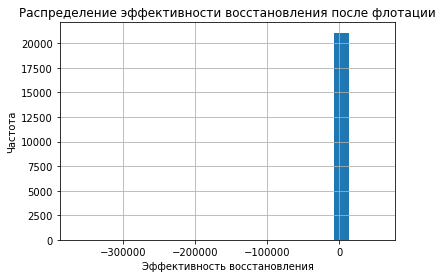

In [60]:
ch1 = df_full_new['check_rough'].hist(bins=20);
pl.title('Распределение эффективности восстановления после флотации')
ch1.set_xlabel("Эффективность восстановления");
ch1.set_ylabel("Частота");

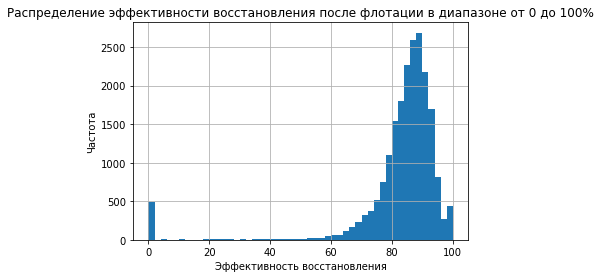

In [61]:
ch2 = df_full_new['check_rough'].hist(bins=50, range=(0, 100));
pl.title('Распределение эффективности восстановления после флотации в диапазоне от 0 до 100%')
ch2.set_xlabel("Эффективность восстановления");
ch2.set_ylabel("Частота");

Эффективность не может принимать отрицательные значения, которые получаются в расчётах при больших отвальных хвостах. Также наблюдаются большие выбросные значения > 100, но эффективность измеряется от 0 до 100.

In [62]:
print(len(df_full_new[(df_full_new['check_rough'] < 0) | (df_full_new['check_rough'] > 100)])/len(df_full_new)*100, '%')
print(len(df_full_new[(df_full_new['check_fin'] < 0) | (df_full_new['check_fin'] > 100)])/len(df_full_new)*100, '%')

1.6691166010716487 %
0.9436198966285743 %


Удалим выбросы

In [63]:
df_full_new = df_full_new.loc[(df_full_new['check_rough'] > 0) & (df_full_new['check_rough'] <= 100)].reset_index(drop = True)
df_full_new = df_full_new.loc[(df_full_new['check_fin'] > 0) & (df_full_new['check_fin'] <= 100)].reset_index(drop = True)

In [64]:
df_train_new = df_train_new.loc[(df_train_new['check_rough'] > 0) & (df_train_new['check_rough'] <= 100)].reset_index(drop = True)
df_train_new = df_train_new.loc[(df_train_new['check_fin'] > 0) & (df_train_new['check_fin'] <= 100)].reset_index(drop = True)

#### Проверка обработки

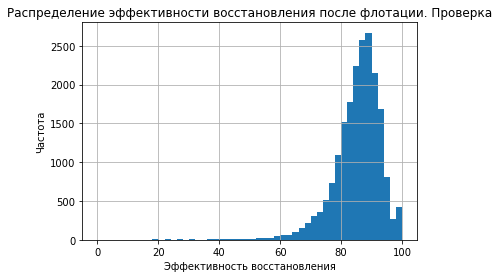

In [65]:
ch0 = df_full_new['check_rough'].hist(bins=50);
pl.title('Распределение эффективности восстановления после флотации. Проверка')
ch0.set_xlabel("Эффективность восстановления");
ch0.set_ylabel("Частота");

Проверка расчётных показателей эффективностей на пропуски

In [66]:
df_full_new.isnull().sum().sort_values(ascending = False).head()

rough_diff                                            965
rougher.output.recovery                               965
fin_diff                                                3
final.output.recovery                                   3
rougher.calculation.floatbank11_sulfate_to_au_feed      0
dtype: int64

In [67]:
df_train_new.isnull().sum().sort_values(ascending = False).head()

rough_diff                                            893
rougher.output.recovery                               893
fin_diff                                                3
final.output.recovery                                   3
rougher.calculation.floatbank11_sulfate_to_au_feed      0
dtype: int64

#### Заменим пропуски в целевых переменных на расчётные

In [68]:
df_full_new[df_full_new['final.output.recovery'].isna() == True][['final.output.recovery', 'check_fin']].head(3)

,final.output.recovery,check_fin
17820,nan,100.00
17821,nan,100.00
17822,nan,100.00


In [69]:
df_full_new[df_full_new['rougher.output.recovery'].isna() == True][['rougher.output.recovery', 'check_rough']].head(3)

,rougher.output.recovery,check_rough
90,nan,31.86
91,nan,19.57
92,nan,64.48


In [70]:
df_full_new['rougher.output.recovery'] = df_full_new['rougher.output.recovery'].fillna(df_full_new['check_rough'])
df_train_new['rougher.output.recovery'] = df_train_new['rougher.output.recovery'].fillna(df_train_new['check_rough'])

In [71]:
df_full_new['final.output.recovery'] = df_full_new['final.output.recovery'].fillna(df_full_new['check_fin'])
df_train_new['final.output.recovery'] = df_train_new['final.output.recovery'].fillna(df_train_new['check_fin'])

#### Добавим целевые переменные к тестовой выборке

In [72]:
df_test_new['rougher.output.recovery'] = df_test_new.date.map(df_full_new.set_index('date')['rougher.output.recovery']) 

In [73]:
df_test_new['final.output.recovery'] = df_test_new.date.map(df_full_new.set_index('date')['final.output.recovery']) 

Проверка

In [74]:
df_test_new.isnull().sum().sort_values(ascending = False).head(3)

final.output.recovery            614
rougher.output.recovery          614
primary_cleaner.input.sulfate      0
dtype: int64

In [75]:
df_test_new = df_test_new.dropna().reset_index(drop = True)

**Вывод.** На данном этапе мы представили обзор исследуемых данных, группировали все признаки по стадиям очистки металлов, подробно рассмотрели переменные эффективности восстановления золота. Также мы обработали пропущенные значения как целевых признаков (с помощью расчёта), так и нецелевых, в основном заменив их на значения за предыдущий период времени. Обработали выбросные значения.    
Была проведена подготовка тестовой выборки - добавили зависимые переменные.

# 2. Анализ данных       <a id="analysis"></a>

### Концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [76]:
au = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
ag = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
pb = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']

In [77]:
def stages(df, el, name):
    i = 0
    print('Средняя концентрация', name, 'на разных этапах очистки \n')
    for col in df[el]:
        i += 1
        print('Этап', i, ': {:.2f}'.format(df[col].mean()))    

In [78]:
stages(df_train_new, au, 'au')

Средняя концентрация au на разных этапах очистки 

Этап 1 : 7.74
Этап 2 : 19.43
Этап 3 : 31.48
Этап 4 : 42.99


In [79]:
stages(df_train_new, ag, 'ag')

Средняя концентрация ag на разных этапах очистки 

Этап 1 : 8.44
Этап 2 : 11.80
Этап 3 : 8.02
Этап 4 : 5.11


In [80]:
stages(df_train_new, pb, 'pb')

Средняя концентрация pb на разных этапах очистки 

Этап 1 : 3.45
Этап 2 : 7.67
Этап 3 : 9.24
Этап 4 : 9.92


In [81]:
def plot(df, el):
    parts=[]
    for col in df[el]:
        parts.append(df[col].mean())
    return parts

In [82]:
au_dynamics = plot(df_train_new, au)
ag_dynamics = plot(df_train_new, ag)
pb_dynamics = plot(df_train_new, pb)

In [83]:
d = pd.DataFrame({'stage':['Before', 'Flotation', 'Primary cleaner', 'Secondary cleaner'], 
                                              'au_dynamics':au_dynamics, 'ag_dynamics':ag_dynamics, 'pb_dynamics':pb_dynamics})

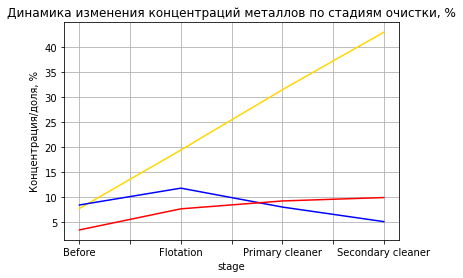

In [84]:
ax = d.groupby('stage')['au_dynamics'].mean().plot(kind= 'line', grid=True, color='gold', title='Динамика изменения концентраций металлов по стадиям очистки, %')
d.groupby('stage')['ag_dynamics'].mean().plot(kind= 'line', grid=True, color='blue')
d.groupby('stage')['pb_dynamics'].mean().plot(kind= 'line', grid=True, color='red')
ax.set_ylabel('Концентрация/доля, %')
plt.show()

При сравнении концентраций металлов на разных этапах очистки, можно заметить, что доля золота растёт заметнее всего: в среднем доля увеличивается с 7.7% до 43%. Концентрация свинца также увеличивается, но заметно медленнее и в среднем доля увеличилась на 6.5%. Изменение концентраций серебра в среднем меняется иначе: на 2ой стадии наблюдается рост, а далее доля серебра в смеси металлов снижается.

### Сравнения распределений размеров гранул сырья на разных выборках

Нам доступны данные по размерам гранул сырья перед флотацией и перед первым этапом очистки, сравним эти значения на тестовой и обучающей выборках. Необходимо чтобы гранулы были схожего размера, так как для обработки гранул большего размера требуется больше реагентов и наоборот. 

In [85]:
display(df_train_new['rougher.input.feed_size'].describe())
display(df_test_new['rougher.input.feed_size'].describe())

count   14688.00
mean       59.65
std        23.22
min         9.66
25%        48.41
50%        54.99
75%        65.58
max       484.97
Name: rougher.input.feed_size, dtype: float64

count   5226.00
mean      56.49
std       21.93
min        0.05
25%       43.91
50%       51.28
75%       62.65
max      477.45
Name: rougher.input.feed_size, dtype: float64

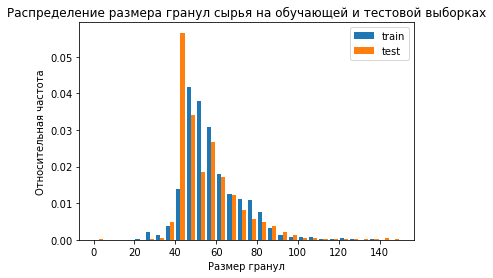

In [86]:
plt.hist([df_train_new['rougher.input.feed_size'], df_test_new['rougher.input.feed_size']], bins=30, density=True, range=(0, 150));
plt.title('Распределение размера гранул сырья на обучающей и тестовой выборках')
plt.legend(['train', 'test'])
plt.xlabel("Размер гранул");
plt.ylabel("Относительная частота");

Согласно статье "Comparative evaluation between mechanical and pneumatic cells for quartz flotation in the iron ore industry" (Lima, N. Pereira, et al., 2018) максимальный размер гранул сырья при флотации - 150.   
На гистограмме также заметно, что есть значения выше 150, но это скорее выбросы, поэтому удалим аномальные значения.

Распределения размеров гранул сырья на обучающей и тестовой выборках схожи: одинаковая форма распределений, интервал разброса, близки медиана и среднее, поэтому предполагаем, что их можно сравнивать друг с другом.

In [87]:
df_train_new = df_train_new.loc[df_train_new['rougher.input.feed_size'] <= 150].reset_index(drop = True)
df_test_new = df_test_new.loc[df_test_new['rougher.input.feed_size'] <= 150].reset_index(drop = True)

Сравним размеры гранул сырья после флотации

In [88]:
display(df_train_new['primary_cleaner.input.feed_size'].describe())
display(df_test_new['primary_cleaner.input.feed_size'].describe())

count   14572.00
mean        7.31
std         0.61
min         1.08
25%         6.94
50%         7.29
75%         7.68
max        10.47
Name: primary_cleaner.input.feed_size, dtype: float64

count   5206.00
mean       7.26
std        0.61
min        5.65
25%        6.89
50%        7.25
75%        7.59
max       15.50
Name: primary_cleaner.input.feed_size, dtype: float64

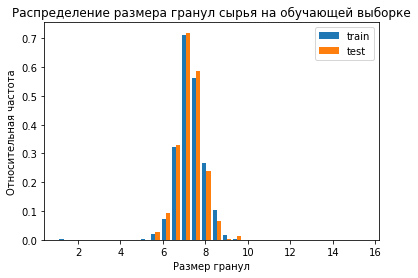

In [89]:
plt.hist([df_train_new['primary_cleaner.input.feed_size'], df_test_new['primary_cleaner.input.feed_size']], bins=30, density=True);
plt.title('Распределение размера гранул сырья на обучающей выборке')
plt.legend(['train', 'test'])
plt.xlabel("Размер гранул");
plt.ylabel("Относительная частота");

Можем заметить, что средние значения переменных почти равны и распределения схожи, однако распределение обучающей смещено влево, а тестовой - вправо. Оставим только значения из обего диапазона двух распределений. 

In [90]:
df_train_new = df_train_new.loc[df_train_new['primary_cleaner.input.feed_size'] >= 
                                              df_test_new['primary_cleaner.input.feed_size'].min()].reset_index(drop = True)

df_test_new = df_test_new.loc[df_test_new['primary_cleaner.input.feed_size'] <= 
                                              df_train_new['primary_cleaner.input.feed_size'].max()].reset_index(drop = True)

### Суммарная концентрация всех веществ на разных стадиях

In [91]:
def sum_concentr(df, stage, name):
    print('СТАДИЯ:', name)
    print("Квантиль-1%: {:.2f} \n".format(df[stage].sum(axis=1).quantile(0.01)))
    h = df[stage].sum(axis=1).hist(bins=50)
    pl.title('Суммарная концентрация всех веществ')
    h.set_xlabel("Суммарная концентрация")
    h.set_ylabel("Частота")

СТАДИЯ: Смесь руды до очистки
Квантиль-1%: 0.04 



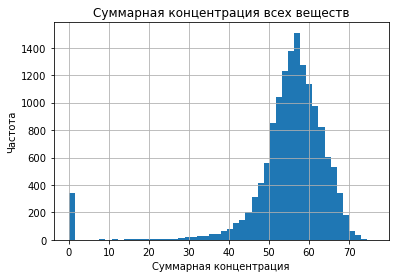

In [92]:
sum_concentr(df_train_new, feed, 'Смесь руды до очистки')

СТАДИЯ: Смесь руды до очистки
Квантиль-1%: 37.24 



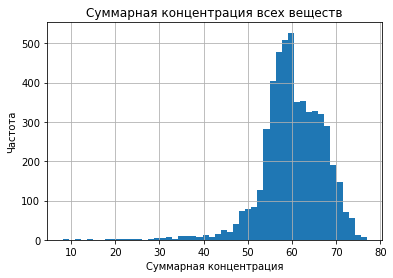

In [93]:
sum_concentr(df_test_new, feed, 'Смесь руды до очистки')

СТАДИЯ: Суммарная концентрация руды после флотации
Квантиль-1%: 0.04 



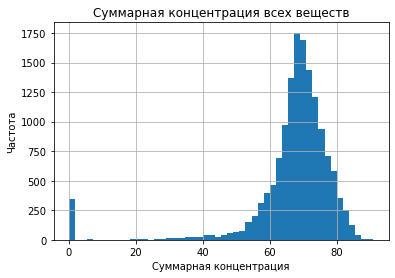

In [94]:
sum_concentr(df_train_new, rougher_concentrate, 'Суммарная концентрация руды после флотации')

СТАДИЯ: Суммарная концентрация руды после 1го этапа очистки
Квантиль-1%: 0.04 



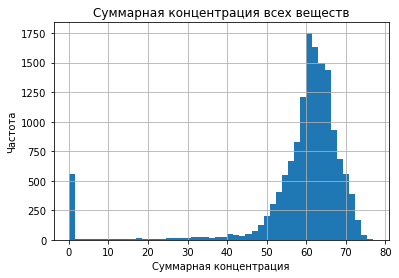

In [95]:
sum_concentr(df_train_new, primary_concentrate, 'Суммарная концентрация руды после 1го этапа очистки')

СТАДИЯ: Суммарная концентрация руды после 2го этапа очистки
Квантиль-1%: 0.04 



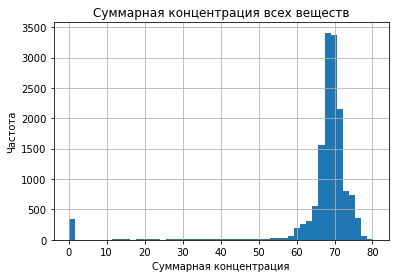

In [96]:
sum_concentr(df_train_new, final_concentrate, 'Суммарная концентрация руды после 2го этапа очистки')

**Вывод.** Для тестовой выборки доступны данные только по концентрации металлов до флотации, а для обучающей - по всем стадиям очистки. На всех этапах распределения смещены влево - присутствует "хвост" с маленькими значениями, также заметно большое кол-во нулевых значений. После флотации наблюдается больше всего нулевых значений.    
Чтобы сравнение данных обучающей и тестовой выборок было корректным, уберём значения меньше минимальных тестовой выборки. Как уже говорили ранее, если концентрация металлов в начале близка к 0, то в очистке и нет смысла.

#### Аномалии

In [97]:
df_train_new['sum_feed'] = df_train_new[feed].sum(axis=1)

In [98]:
df_train_new = df_train_new.loc[df_train_new['sum_feed'] >= 
                        df_test_new[feed].sum(axis=1).min()].reset_index(drop = True)

**Вывод.** Можем наблюдать аномальные нулевые или близкие к 0 значения у обучающей выборки. Нам известны только доли металлов в руде до процессов очистки, однако в зависимости от параметров флотационной установки и последующих очисток эти доли меняются и могут становиться 0.    
Нам не следует удалять нулевые значения из других этапов очистки, поскольку они важны для оценки признаков, влияющих на эффективность, так как они появляются уже в процессе, то есть модель может отследить негативное влияние факторов.

In [99]:
df_train_new[recovery].describe().T

,count,mean,std,min,25%,50%,75%,max
rougher.output.recovery,14151.00,84.56,8.09,2.24,80.45,85.61,90.30,99.98
final.output.recovery,14151.00,66.90,9.51,0.09,62.76,67.53,72.43,100.00


In [100]:
df_test_new[recovery].describe().T

,count,mean,std,min,25%,50%,75%,max
rougher.output.recovery,5204.00,86.61,5.90,10.43,84.73,87.46,89.77,99.17
final.output.recovery,5204.00,69.10,7.45,2.03,65.78,69.95,73.33,100.00


Распределений целевых признаков у обех выборок схожи

# 3. Модель    <a id="model"></a>

Обозначим признаки.  
Переменные с концентрациями и отвальными хвостами не будем включать в модель, чтобы избежать "утечку" целевого признака, а также по формуле можно предсказать коэффициенты переменных без регрессий.   
На изменение концентраций на разных стадиях влияют внешние реагенты, которые добавляют для стимулирования процесса обогащения металлов. Также на процессы восстановления влияют компоненты состояния процессов - объём воздуха и уровень жидкости.  
Одним из важных признаков могут быть изначальные доли металлов в руде, размер гранул и их скорость подачи.

In [101]:
features = feed + ['rougher.input.feed_rate', 'rougher.input.feed_size'] + rougher_input + rougher_state + primary_input + primary_state + secondary_state

In [102]:
target_train = df_train_new[recovery]
features_train = df_train_new[features]

In [103]:
print(target_train.shape)
print(features_train.shape)

(14151, 2)
(14151, 51)


In [104]:
target_test = df_test_new[recovery]
features_test = df_test_new[features]

In [105]:
print(target_test.shape)
print(features_test.shape)

(5204, 2)
(5204, 51)


####  Функция sMAPE               <a id="smape"></a>

$$
sMAPE = \frac{1}{N} \sum \limits _{i=1} ^{N} \frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|)/2} *100
$$
  
  
$$
sMAPE_{итог} = 0.25*sMAPE_{rough} + 0.75*sMAPE_{final}
$$

Необходимо предсказать вектор значений сразу для двух переменных

In [106]:
def smape(target, predictions, **kwargs):
    err1 = 0
    err2 = 0
    
    predictions = pd.DataFrame(predictions)
    target = target.reset_index(drop=True)
    
    for i in range(target.shape[0]):
        err1 += ((abs(target.loc[i, 'rougher.output.recovery'] - predictions.loc[i, 0]))/
                 ((abs(target.loc[i, 'rougher.output.recovery']) + abs(predictions.loc[i, 0]))/2))
    
    for i in range(target.shape[0]):
        err2 += ((abs(target.loc[i, 'final.output.recovery'] - predictions.loc[i, 1]))/
                 ((abs(target.loc[i, 'final.output.recovery']) + abs(predictions.loc[i, 1]))/2))
    
    smape_rough = err1 / len(target) * 100 
    smape_fin = err2 / len(target) * 100
    
    return (smape_rough * 0.25 + smape_fin * 0.75) 

In [107]:
smape_score = make_scorer(smape, greater_is_better=False)

In [108]:
# Сравнение распределений признаков обучающей и тестовой выборок

def dist_compar(df1, df2):
    for col in df1.columns:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,2))    
        ax1.hist(df1[col], bins=25, density=True)
        ax1.set_title('Распр-е train: {}'.format(col))
        ax2.hist(df2[col], bins=25, density=True)
        ax2.set_title('Распр-е test: {}'.format(col))

### Найдём наилучшую модель

**Функция для отображения feature importances для grid search**

In [109]:
def feat_imp(model):
    scores = model.best_estimator_.feature_importances_

    dff = []    
    for i, f in zip(list(features_train.columns), scores):
            dff.append([i, round(f*100, 2)])

    data = pd.DataFrame (dff, columns = ['feature', 'score'])  
    
    return data.sort_values('score', ascending=False)

#### Linear Regression

In [110]:
lin = LinearRegression()
lin.fit(features_train, target_train)
res_tr = cross_val_score(lin, features_train, target_train, cv=5, scoring = smape_score).mean()

pred_lin = lin.predict(features_test)
res_test = smape(target_test, pred_lin)

In [111]:
print("sMAPE train: {:.1f}".format(-res_tr))
print("sMAPE test: {:.1f}".format(res_test))

sMAPE train: 10.0
sMAPE test: 7.6


#### Decision Tree Regressor

In [112]:
parametrs_dt = {'max_depth': range(1, 9, 2),
                'max_features': ['auto', 'sqrt'],
                'random_state': [42]}

In [113]:
%%time
dt = DecisionTreeRegressor()
grid_dt = GridSearchCV(dt, parametrs_dt, scoring = smape_score, cv=5)
grid_dt.fit(features_train, target_train)

Wall time: 11.7 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 9, 2),
                         'max_features': ['auto', 'sqrt'],
                         'random_state': [42]},
             scoring=make_scorer(smape, greater_is_better=False))

In [114]:
print('sMAPE: {:.2f}\n'.format(-grid_dt.best_score_),
                                grid_dt.best_params_)

sMAPE: 9.11
 {'max_depth': 3, 'max_features': 'auto', 'random_state': 42}


In [115]:
feat_imp(grid_dt).head(10)

,feature,score
0,rougher.input.feed_ag,45.67
11,rougher.state.floatbank10_a_level,21.16
7,rougher.input.floatbank10_xanthate,11.70
43,secondary_cleaner.state.floatbank4_b_air,8.54
22,primary_cleaner.input.sulfate,7.58
40,secondary_cleaner.state.floatbank3_b_level,2.87
5,rougher.input.feed_size,2.48
38,secondary_cleaner.state.floatbank3_a_level,0.00
30,primary_cleaner.state.floatbank8_c_level,0.00
31,primary_cleaner.state.floatbank8_d_air,0.00


In [116]:
predict_dt_test = grid_dt.predict(features_test)
sm_dt = smape(target_test, predict_dt_test)
print("Final sMAPE: {:.2f}".format(sm_dt))

Final sMAPE: 6.78


In [117]:
imp = list(feat_imp(grid_dt)['feature'].head(5))

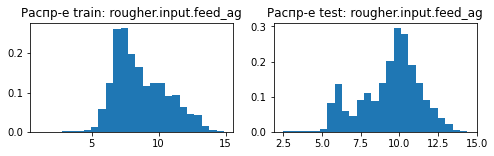

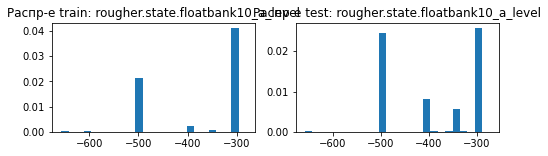

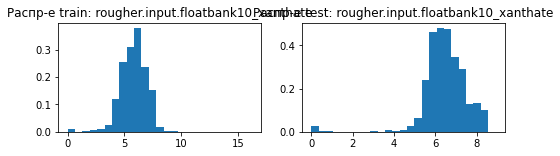

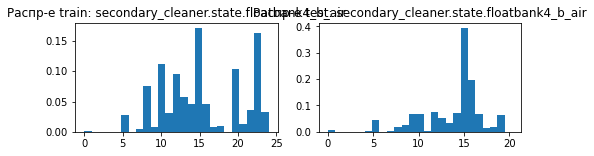

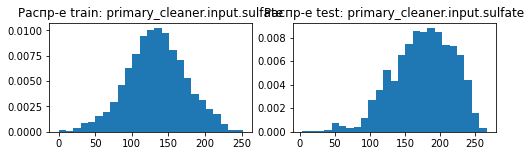

In [118]:
dist_compar(features_train[imp], features_test[imp])

При подборе гиперпараметров у дерева решений лучшее качество оказалось с макисмальной глубиной = 3. При кросс-валидации обучающей выборки лучший результат sMAPE = 9.1. А при предсказании тестовых значений sMAPE = 6.8.   
В анализе feature importance представлены признаки, которые оказали наиболее значимое влияние на прогноз. Так как тестовое значение оказалось лучше обучения, были приведены распределения этих признаков в относительных частотах. Можем заметить, что распределение многих признаков у обучающей и тестовой выборок заметно отличаются.    

#### Random Forest Regressor

In [119]:
parametrs_rf = {'n_estimators': [10, 20, 50, 110],
                'max_depth': range(1, 9, 2),
                'max_features': ['auto', 'sqrt'],
                'random_state': [42]}

In [120]:
%%time
rf = RandomForestRegressor()
grid_rf = GridSearchCV(rf, parametrs_rf, scoring = smape_score, cv=5)
grid_rf.fit(features_train, target_train);

Wall time: 9min 26s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 9, 2),
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [10, 20, 50, 110],
                         'random_state': [42]},
             scoring=make_scorer(smape, greater_is_better=False))

In [121]:
print('sMAPE: {:.2f}\n'.format(-grid_rf.best_score_),
                                grid_rf.best_params_)

sMAPE: 8.38
 {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 50, 'random_state': 42}


In [122]:
feat_imp(grid_rf).head(10)

,feature,score
0,rougher.input.feed_ag,9.14
22,primary_cleaner.input.sulfate,8.64
43,secondary_cleaner.state.floatbank4_b_air,7.70
3,rougher.input.feed_au,6.49
14,rougher.state.floatbank10_c_air,4.77
16,rougher.state.floatbank10_d_air,3.88
41,secondary_cleaner.state.floatbank4_a_air,3.55
33,secondary_cleaner.state.floatbank2_a_air,3.31
9,rougher.input.floatbank11_xanthate,3.28
7,rougher.input.floatbank10_xanthate,3.23


In [123]:
predict_rf_test = grid_rf.predict(features_test)
sm_rf = smape(target_test, predict_rf_test)
print("Final sMAPE: {:.2f}".format(sm_rf))

Final sMAPE: 6.71


In [124]:
imp = list(feat_imp(grid_rf)['feature'].head(5))

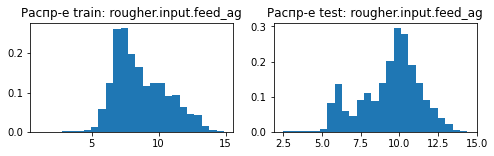

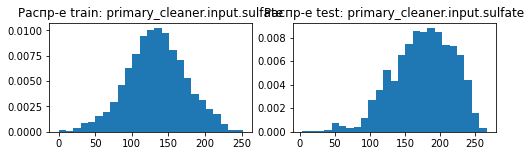

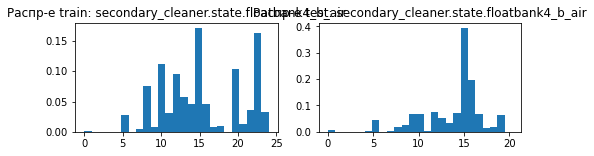

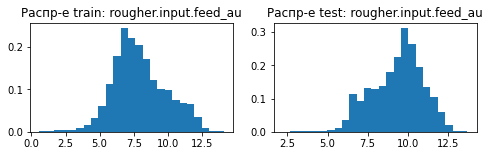

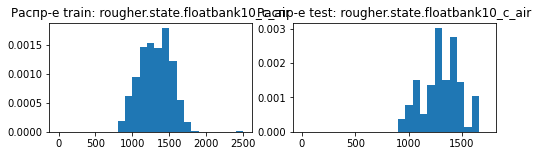

In [125]:
dist_compar(features_train[imp], features_test[imp])

При подборе гиперпараметров у случайного леса лучшее качество оказалось у модели с максимальной глубиной = 7, кол-вом деревьев = 50. sMAPE  оказался лучше, чем у дерева и составил 8.4 на обучающей выборке (при кросс-валидации) и 6.7 на тестовой выборке. Также можем заметить разницу распределений наиболее значимых признаков.

#### Предсказание средних    <a id="test"></a>

Проверим модель с предсказанием медианного значения

In [126]:
target_pred_const1 = pd.Series(target_train['rougher.output.recovery'].median(), index=target_train.index)
target_pred_const2 = pd.Series(target_train['final.output.recovery'].median(), index=target_train.index)

In [127]:
target_pred_const11 = pd.DataFrame({0: target_pred_const1, 1: target_pred_const2})

In [128]:
sm_m_train = smape(target_train, target_pred_const11)
print("sMAPE модели с предсказаниями средних: {:.2f}".format(sm_m_train))

sMAPE модели с предсказаниями средних: 9.54


In [129]:
target_pred_const3 = pd.Series(target_test['rougher.output.recovery'].median(), index=target_test.index)
target_pred_const4 = pd.Series(target_test['final.output.recovery'].median(), index=target_test.index)

In [130]:
target_pred_const22 = pd.DataFrame({0: target_pred_const3, 1: target_pred_const4})

In [131]:
sm_m_test = smape(target_test, target_pred_const22)
print("sMAPE модели с предсказаниями средних: {:.2f}".format(sm_m_test))

sMAPE модели с предсказаниями средних: 6.84


### Сравним полученные значения всех моделей

In [132]:
values = ([-res_tr, -grid_dt.best_score_, -grid_rf.best_score_, sm_m_train],
         [res_test, sm_dt, sm_rf, sm_m_test])

concl = pd.DataFrame(values, columns = ['LR', 'DT','RF', 'M'], index=['train', 'test'])

In [133]:
concl

,LR,DT,RF,M
train,9.96,9.11,8.38,9.54
test,7.55,6.78,6.71,6.84


При сравнении sMAPE моделей наилучшей оказался случайный лес, как для обучающей, так и для тестовой выборок (8,4 и 6,7 соответственно). Предсказание медианными значениями оказалось лучше линейной регрессии, но немного хуже дерева и леса. Можем заметить, что предсказание леса ненамного лучше медианного на тестовой выборке. Также во всех случаях предсказания обучающей выборки хуже, чем тестовой. Такие результаты могли получиться по причине неравномерного деления на тестовую и обучающую выборки: значения по месяцам разделены не пропорционально, что наблюдается в сравнении распределений наиболее значимых для предсказания переменных. 

### Общий вывод               <a id="concl"></a>

В датафрейме содержатся наблюдения поочистке руды за каждый час на протяжении почти 1,5 года. В данных присутствовали пропущенные и аномальные значения, большинство мы обработали заменой значения на наблюдение предыдущего часа.
Можем отметить, что на протяжении всего процесса очистки концентрация золота растёт заметнее остальных и в среднем составила 43% от смеси на финальной стадии.  
В задании требовалось предсказать векторы по двум значениям, поэтому были выбраны не бустинговые модели.

На основе данных о добыче и очистке металлов, мы построили модели, которые предсказывают коэффициент восстановления золота из руды. На основе метрики sMAPE была выбрана модель случайного леса. Тестирование модели показало sMAPE = 6,7%.   
На эффективность восстановления оказывают влияние такие факторы, как доля руды в начальной смеси, разные составы реагентов, параметры флотационной установки (вода, воздух), размер гранул сырья и другие.    
Распределение признаков на тестовой и обучающей выборке отличаются. Возможно, в обучающей выборке больше "сложных" случаев, поэтому тестовое sMAPE оказалось лучше.  